In [1]:
import os 
import time 
import uuid 
import cv2
import json 
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [2]:
# check gpu availability 
import tensorflow.python.platform.build_info as build
print(f'Tf build info:\n{build.build_info}\n')
print(f'Device list: {tf.config.list_physical_devices()}\n')
print(f'GPU device name: {tf.test.gpu_device_name()}')
print(f'Tf built with cuda: {tf.test.is_built_with_cuda()}')

Tf build info:
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])

Device list: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU device name: /device:GPU:0
Tf built with cuda: True


# Collecting Images

In [3]:
# FIRST TIME RUN ONLY
IMAGES_PATH = os.path.join('data', 'images')
# total images: 120
NUM_IMGS = 20

Capture images in batches of 20 using the laptop's webcam. Images are named using `uuid` and then saved to the images folder.  

In [4]:
# FIRST TIME RUN ONLY
capture = cv2.VideoCapture(0)
for img_idx in range(NUM_IMGS):
    ret, frame = capture.read() 
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()

Annotate images using LabelMe.

In [10]:
# FIRST TIME RUN ONLY
!labelme 

# Limit GPU Memory Growth

In [3]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Build and Review Dataset

Move images into train, val, and test folders. 

In [4]:
folders = ['train', 'val', 'test']

In [24]:
# FIRST TIME RUN ONLY
# partition percentages 
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

files = [f for f in os.listdir(os.path.join('data', 'images')) if os.path.isfile(os.path.join('data', 'images', f))]
num_files = len(files)
train_num = num_files * TRAIN_SIZE
val_num = num_files * VAL_SIZE
test_num = num_files * VAL_SIZE

print(f'Num files: {num_files}')
print(f'Train size: {train_num}')
print(f'Val size: {val_num}')
print(f'Test size: {test_num}')

Num files: 140
Train size: 98.0
Val size: 21.0
Test size: 21.0


In [93]:
# FIRST TIME RUN ONLY
# target folders 
partitions = {folders[0]: 0, folders[1]: 0, folders[2]: 0}
file_idx = 0

while file_idx < num_files:

    file = files[file_idx]
    dest_folder = np.random.choice(a = folders, size = 1, p = [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])[0]
    curr_file_path = os.path.join('data', 'images', file)
    new_file_path = os.path.join('data', 'images', dest_folder, file)

    if dest_folder == 'train':
        if partitions[dest_folder] < train_num:
            os.replace(curr_file_path, new_file_path)
            partitions[dest_folder] += 1
        else:
            continue 

    elif dest_folder == 'val': 
        if partitions[dest_folder] < val_num:
            os.replace(curr_file_path, new_file_path)
            partitions[dest_folder] += 1
        else:
            continue
    
    elif dest_folder == 'test':
        if partitions[dest_folder] < test_num:
            os.replace(curr_file_path, new_file_path)
            partitions[dest_folder] += 1
        else:
            continue 
    
    file_idx += 1

Move matching label files into the correct train, val, and test folders. 

In [94]:
# FIRST TIME RUN ONLY
for folder in folders:
    for file in os.listdir(os.path.join('data', 'images', folder)):
        label_filename = file.split('.')[0] + '.json' 
        curr_file_path = os.path.join('data', 'labels', label_filename)
        if os.path.exists(curr_file_path):
            new_file_path = os.path.join('data', 'labels', folder, label_filename)
            os.replace(curr_file_path, new_file_path)

# Albumentations 

In [5]:
# FIRST TIME RUN ONLY
transformer = A.Compose([
    A.RandomCrop(width = 450, height = 450),
    A.HorizontalFlip(p = 0.5),
    A.RandomBrightnessContrast(p = 0.2),
    A.RandomGamma(p = 0.2),
    A.RGBShift(p = 0.2),
    A.VerticalFlip(p = 0.5)], 
    bbox_params = A.BboxParams(format = 'albumentations', label_fields = ['class_labels'])
)

## Test that the albumentations compose transformer works with one of the training images.

In [101]:
tmp_img = cv2.imread(os.path.join('data', 'images', 'train', '01ed877a-9c62-11ed-9939-8cb87e8f1316.jpg'))
tmp_img

array([[[129,  79,  73],
        [128,  78,  72],
        [129,  77,  71],
        ...,
        [123, 137, 136],
        [124, 136, 136],
        [124, 136, 136]],

       [[128,  78,  72],
        [128,  78,  72],
        [129,  77,  71],
        ...,
        [123, 137, 136],
        [124, 136, 136],
        [124, 136, 136]],

       [[128,  78,  72],
        [127,  77,  71],
        [130,  78,  71],
        ...,
        [124, 136, 136],
        [124, 136, 136],
        [124, 136, 136]],

       ...,

       [[ 61,  63,  64],
        [ 62,  64,  65],
        [ 62,  64,  65],
        ...,
        [ 94, 103, 117],
        [ 94, 103, 117],
        [ 94, 103, 117]],

       [[ 63,  62,  64],
        [ 63,  62,  64],
        [ 64,  63,  65],
        ...,
        [ 93, 102, 115],
        [ 94, 103, 117],
        [ 93, 102, 116]],

       [[ 63,  62,  64],
        [ 63,  62,  64],
        [ 63,  62,  64],
        ...,
        [ 93, 102, 115],
        [ 93, 102, 116],
        [ 92, 101, 115]]

In [102]:
with open(os.path.join('data', 'labels', 'train', '01ed877a-9c62-11ed-9939-8cb87e8f1316.json'), 'r') as f:
    tmp_label = json.load(f)
tmp_label

{'version': '5.1.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[238.4065934065934, 188.62637362637363],
    [404.34065934065933, 395.7692307692308]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\01ed877a-9c62-11ed-9939-8cb87e8f1316.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZH

In [107]:
tmp_label['shapes'][0]['label']

'face'

In [104]:
coords = tmp_label['shapes'][0]['points']
coords

[[238.4065934065934, 188.62637362637363],
 [404.34065934065933, 395.7692307692308]]

In [105]:
tmp_bbox = [
    coords[0][0], 
    coords[0][1], 
    coords[1][0], 
    coords[1][1]
]
tmp_bbox

[238.4065934065934, 188.62637362637363, 404.34065934065933, 395.7692307692308]

In [106]:
tmp_bbox = list(np.divide(tmp_bbox, [640, 480, 640, 480]))
tmp_bbox

[0.3725103021978022,
 0.3929716117216117,
 0.6317822802197802,
 0.8245192307692307]

In [117]:
len(coords)

2

In [133]:
tmp_transformed = transformer(image = tmp_img, bboxes = [tmp_bbox], class_labels = [tmp_label['shapes'][0]['label']])

In [134]:
tmp_transformed['image']

array([[[158, 174, 173],
        [158, 174, 173],
        [158, 174, 173],
        ...,
        [137,  79,  67],
        [135,  80,  67],
        [136,  81,  68]],

       [[158, 174, 173],
        [158, 174, 173],
        [158, 174, 173],
        ...,
        [138,  80,  68],
        [136,  80,  69],
        [136,  80,  69]],

       [[158, 174, 173],
        [158, 174, 173],
        [158, 174, 173],
        ...,
        [138,  80,  68],
        [136,  80,  69],
        [136,  80,  69]],

       ...,

       [[ 43,  39,  51],
        [ 43,  39,  51],
        [ 45,  39,  50],
        ...,
        [ 66,  77,  75],
        [ 66,  77,  75],
        [ 65,  76,  74]],

       [[ 43,  39,  51],
        [ 43,  39,  51],
        [ 46,  40,  51],
        ...,
        [ 66,  77,  75],
        [ 65,  76,  74],
        [ 64,  75,  73]],

       [[ 43,  39,  50],
        [ 44,  40,  51],
        [ 44,  40,  51],
        ...,
        [ 66,  77,  75],
        [ 65,  76,  74],
        [ 64,  75,  73]]

In [135]:
len(tmp_transformed['bboxes'])

1

In [137]:
tmp_transformed['bboxes']

[(0.14146520146520147,
  0.38139194139194144,
  0.5102075702075702,
  0.8417094017094017)]

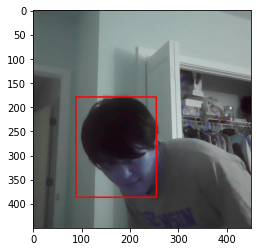

In [115]:
cv2.rectangle(
    tmp_transformed['image'],
    tuple(np.multiply(tmp_transformed['bboxes'][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(tmp_transformed['bboxes'][0][2:], [450, 450]).astype(int)),
    (255, 0, 0),
    2
)
plt.imshow(tmp_transformed['image'])

# Build Albumentation Compose Pipeline

In [8]:
# FIRST TIME RUN ONLY
# how many augmented images to create based off each base image 
IMAGE_PER_BASE_IMAGE = 50

# loop through each data partition 
for folder in folders:
    for image in os.listdir(os.path.join('data', 'images', folder)):
        
        curr_img = cv2.imread(os.path.join('data', 'images', folder, image))

        bbox_coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', 'labels', folder, f'{image.split(".")[0]}.json')

        # check if label exists (some images don't have labels)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                curr_label = json.load(f) 
            
            curr_bbox = curr_label['shapes'][0]['points']
            bbox_coords[0] = curr_bbox[0][0]
            bbox_coords[1] = curr_bbox[0][1]
            bbox_coords[2] = curr_bbox[1][0]
            bbox_coords[3] = curr_bbox[1][1]
            bbox_coords = list(np.divide(bbox_coords, [640, 480, 640, 480]))
        
        try:
            for x in range(IMAGE_PER_BASE_IMAGE):

                transformed = transformer(image = curr_img, bboxes = [bbox_coords], class_labels = ['face'])
                cv2.imwrite(os.path.join('augmented_data', folder, 'images', f'{image.split(".")[0]}.{x}.jpg'), transformed['image'])

                label_annotation = {}
                label_annotation['image'] = image 

                if os.path.exists(label_path):
                    if len(transformed['bboxes']) == 0:
                        label_annotation['bbox'] = [0, 0, 0, 0]
                        label_annotation['class'] = 0
                    else:
                        label_annotation['bbox'] = transformed['bboxes'][0]
                        label_annotation['class'] = 1 
                else:
                    label_annotation['bbox'] = [0, 0, 0, 0]
                    label_annotation['class'] = 0
                
                with open(os.path.join('augmented_data', folder, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(label_annotation, f)

        except Exception as e:
            print(e)

In [5]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [6]:
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

# Load Data Into Tensorflow Dataset


In [7]:
train_images = tf.data.Dataset.list_files('augmented_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x : tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x : x / 255)

val_images = tf.data.Dataset.list_files('augmented_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x : tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x : x / 255)

test_images = tf.data.Dataset.list_files('augmented_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x : tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x : x / 255)

# Load Labels Into Tensorflow Dataset


In [8]:
train_labels = tf.data.Dataset.list_files('augmented_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('augmented_data\\val\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('augmented_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

# Combine Image and Label Data

In [9]:
# check partition sizes 
print(f'Train | Images: {len(train_images)}  Labels: {len(train_labels)}')
print(f'Val   | Images: {len(val_images)}  Labels: {len(val_labels)}')
print(f'Test  | Images: {len(test_images)}  Labels: {len(test_labels)}')

Train | Images: 4900  Labels: 4900
Val   | Images: 1050  Labels: 1050
Test  | Images: 1050  Labels: 1050


In [10]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(8)
val = val.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(8)
test = test.prefetch(4)

# Peak at Dataset

In [11]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


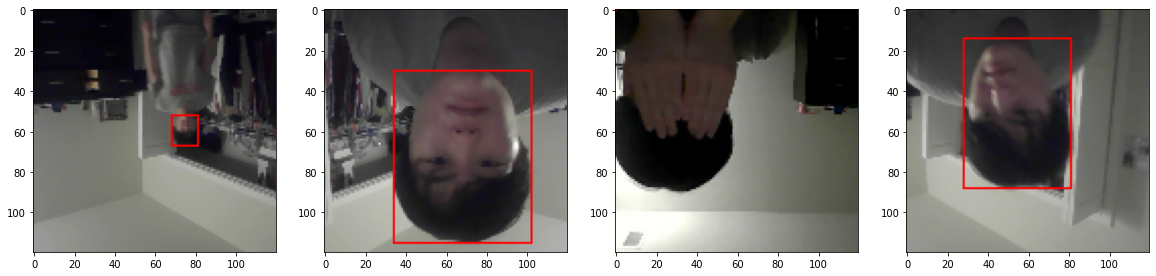

In [12]:
test_samples = train.as_numpy_iterator()
next = test_samples.next()
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    curr_image = next[0][idx]
    curr_bbox = next[1][1][idx]
    cv2.rectangle(
        curr_image, 
        tuple(np.multiply(curr_bbox[:2], [120, 120]).astype(int)),
        tuple(np.multiply(curr_bbox[2:], [120, 120]).astype(int)),
        (255, 0, 0),
        1)
    ax[idx].imshow(curr_image)

# Optimizer

In [11]:
# set the optimizer 

batches_per_epoch = len(train)
# initial learning rate 
learning_rate = 0.0001
# learning rate decay; to avoid overfitting, we should decrease the learning rate as we train 
lr_decay = (1 / 0.7 - 1) / batches_per_epoch


optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, decay = lr_decay)

# Loss Functions 

Need separate loss metrics for the classificaiton output and the regression output. 

In [12]:
# binary cross entropy loss for the classificaiton outputs 
classification_loss = tf.keras.losses.BinaryCrossentropy()

![yolo-loss](https://github.com/seankim658/TF-Face-Detection/blob/master/reference_images/yolo_loss_function.png?raw=true)    

Manually implementing localization loss based off the Yolo loss function. The first and second terms are used for localization loss. The first term calculates the loss of the center of the predicted bounding box. The second term calculates the loss of the height and width predictions for the bounding box. 

Since we are using albumentations annotation format instead of the yolo format, we will calculate the loss for the predicted (x_min, y_min) point (as opposed to the center of the bounding box).

In [13]:
# create localization loss for regression outputs 
def localization_loss(y_true, y_hat):
    
    center_loss = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:,:2]))
    
    height_true = y_true[:,3] - y_true[:,1]
    # height_true_sqrt = np.sqrt(height_true)

    width_true = y_true[:,2] - y_true[:,0]
    # width_true_sqrt = np.sqrt(width_true)

    height_pred = y_hat[:,3] - y_hat[:,1]
    # height_pred_sqrt = np.sqrt(height_pred)

    width_pred = y_hat[:,2] - y_hat[:,0]
    # width_pred_sqrt = np.sqrt(width_pred)

    # height_width_loss = tf.reduce_sum(tf.square(tf.sqrt(width_true) - tf.sqrt(width_pred)) + tf.square(tf.sqrt(height_true) - tf.sqrt(height_pred)))
    height_width_loss = tf.reduce_sum(tf.square(width_true - width_pred) + tf.square(height_true - height_pred))

    return center_loss + height_width_loss 

# Build the Model Using VGG16 as a Base
Leveraging the Keras Functional API for multiple outputs.

In [14]:
def build_model():
    input_layer = Input(shape = (120, 120, 3))

    vgg = VGG16(include_top = False)(input_layer)

    # classification layers (face detection)
    class_pool = GlobalMaxPooling2D()(vgg)
    classification_layer1 = Dense(2048, activation = 'relu')(class_pool)
    classification_layer2 = Dense(1, activation = 'sigmoid')(classification_layer1)

    # regression layers (bounding box prediction)
    regress_pool = GlobalMaxPooling2D()(vgg)
    regression_layer1 = Dense(2048, activation = 'relu')(regress_pool)
    regression_layer2 = Dense(4, activation = 'sigmoid')(regression_layer1)

    face_detection_model = Model(inputs = input_layer, outputs = [classification_layer2, regression_layer2])
    
    return face_detection_model 

In [15]:
face_detection_model = build_model() 
face_detection_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

# Test Untrained Raw Model 

In [16]:
x, y = train.as_numpy_iterator().next()
x.shape

(8, 120, 120, 3)

In [19]:
face_preds, bbox_preds = face_detection_model.predict(x)
face_preds, bbox_preds

1/1 [==============================] - 3s 3s/step


(array([[0.32535696],
        [0.44786125],
        [0.3449892 ],
        [0.40388736],
        [0.3193826 ],
        [0.40593028],
        [0.43806297],
        [0.3709379 ]], dtype=float32),
 array([[0.43191597, 0.610839  , 0.43309525, 0.76232576],
        [0.48725808, 0.59504366, 0.37118176, 0.7199421 ],
        [0.49396625, 0.5450762 , 0.34219825, 0.6873647 ],
        [0.5125796 , 0.55505025, 0.3741985 , 0.7425643 ],
        [0.45057863, 0.57680416, 0.26469728, 0.7045955 ],
        [0.5812129 , 0.60887396, 0.41728547, 0.73904026],
        [0.4487801 , 0.60593057, 0.41587475, 0.6869012 ],
        [0.46722218, 0.5422116 , 0.3836207 , 0.77363014]], dtype=float32))

In [20]:
y

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3257 , 0.5874 , 0.5527 , 0.846  ],
        [0.599  , 0.4675 , 0.7075 , 0.5884 ],
        [0.     , 0.548  , 0.301  , 0.8765 ],
        [0.4011 , 0.432  , 0.51   , 0.5527 ],
        [0.04575, 0.0697 , 0.329  , 0.3774 ],
        [0.2537 , 0.1372 , 0.6406 , 0.6084 ],
        [0.0637 , 0.3948 , 0.3823 , 0.799  ]], dtype=float16))

In [24]:
localization_loss(y[1], bbox_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=3.187208>

In [23]:
classification_loss(y[0], face_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8784694>

# Train Model

In [17]:
# training pipeline 

class FaceDetection(Model):
    '''
    Training pipeline using the subclassing API. 

    Attributes
    ----------
    model : keras model 
        Model to be trained. 
    **kwargs : arbitrary keyword arguments 
    '''

    def __init__(self, model, **kwargs):
        ''' Constructor. 
        '''
        super().__init__(**kwargs)
        self.model = model 
    
    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        ''' Compile function required by Keras subclassing API. 

        Parameters
        ----------
        optimizer : tensorflow.keras.optimizers.Optimizer 
            Optimizer to minimize the loss function. 
        classification_loss : function 
            Loss fucntion to use for the classification output. 
        localization_loss : function 
            Loss function to use for the bounding box predictions. 
        **kwargs : arbitrary keyword arguments
        '''
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss 
        self.optimizer = optimizer 
    
    def call(self, x, **kwargs):
        ''' Override call() from base Model class. 

        Parameters
        ----------
        x : tf.Tensor 
            Input data. 
        **kwargs : arbitrary keyword arguments 

        Returns
        -------
        tf.Tensor : model prediction 
        '''
        return self.model(x, **kwargs)

    def train_step(self, batch, **kwargs):
        ''' Override train_step() from base Model class.  

        Parameters 
        ----------
        batch : tf.data.Dataset 
            Training data. 
        **kwargs : arbitrary keyword arguments 

        Returns 
        -------
        dict : value of the model's metrics during training step 
        '''
        x, y = batch 

        with tf.GradientTape() as g:
            
            face_preds, bbox_preds = self.model(x, training = True)

            batch_classification_loss = self.classification_loss(y[0], face_preds)
            batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), bbox_preds)

            total_loss = batch_localization_loss + (0.6 * batch_classification_loss)

            gradient = g.gradient(total_loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))

        return {'total_loss': total_loss, 'classification_loss': batch_classification_loss, 'localization_loss': batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        ''' Override test_step() from base Model class. 

        Parameters 
        ----------
        batch : tf.data.Dataset 
            Test data. 
        **kwargs : arbitrary keyword arguments 

        Returns 
        -------
        dict : value of the model's metrics during testing step 
        '''
        x, y = batch 

        face_preds, bbox_preds = self.model(x, training = False)

        batch_classification_loss = self.classification_loss(y[0], face_preds)
        batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), bbox_preds)

        total_loss = batch_localization_loss + (0.6 * batch_classification_loss)

        return {'total_loss': total_loss, 'classification_loss': batch_classification_loss, 'localization_loss': batch_localization_loss}

In [18]:
model = FaceDetection(face_detection_model)
model.compile(optimizer = optimizer, classification_loss = classification_loss, localization_loss = localization_loss)

In [19]:
tensorboard_logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir)

In [20]:
EPOCHS = 10
history = model.fit(train, epochs = EPOCHS, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/10
613/613 [==============================] - 56s 75ms/step - total_loss: 0.3604 - classification_loss: 0.1022 - localization_loss: 0.2991 - val_total_loss: 0.0205 - val_classification_loss: 8.0351e-05 - val_localization_loss: 0.0205
Epoch 2/10
613/613 [==============================] - 47s 71ms/step - total_loss: 0.0747 - classification_loss: 0.0198 - localization_loss: 0.0628 - val_total_loss: 0.0048 - val_classification_loss: 1.6763e-04 - val_localization_loss: 0.0047
Epoch 3/10
613/613 [==============================] - 46s 70ms/step - total_loss: 0.0423 - classification_loss: 0.0117 - localization_loss: 0.0353 - val_total_loss: 0.0090 - val_classification_loss: 8.5645e-04 - val_localization_loss: 0.0085
Epoch 4/10
613/613 [==============================] - 47s 71ms/step - total_loss: 0.0172 - classification_loss: 0.0027 - localization_loss: 0.0156 - val_total_loss: 0.0036 - val_classification_loss: 1.3481e-04 - val_localization_loss: 0.0035
Epoch 5/10
613/613 [============

In [ ]:
history.history 

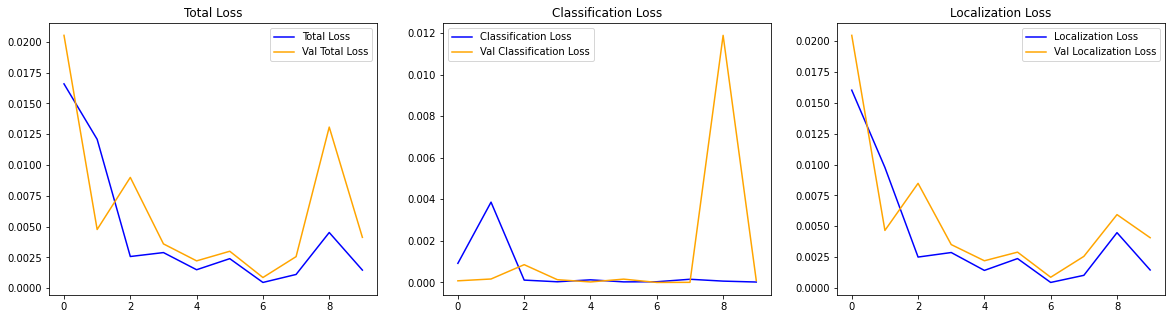

In [21]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))

ax[0].plot(history.history['total_loss'], color = 'blue', label = 'Total Loss')
ax[0].plot(history.history['val_total_loss'], color = 'orange', label = 'Val Total Loss')
ax[0].set_title('Total Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color = 'blue', label = 'Classification Loss')
ax[1].plot(history.history['val_classification_loss'], color = 'orange', label = 'Val Classification Loss')
ax[1].set_title('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color = 'blue', label = 'Localization Loss')
ax[2].plot(history.history['val_localization_loss'], color = 'orange', label = 'Val Localization Loss')
ax[2].set_title('Localization Loss')
ax[2].legend()

# Run on Test Set

In [30]:
test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [33]:
predictions = face_detection_model.predict(test)

132/132 [==============================] - 3s 19ms/step


In [34]:
test_class_preds = np.where(predictions[0] >= 0.5, 1, 0)
test_bbox_preds = predictions[1]

1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


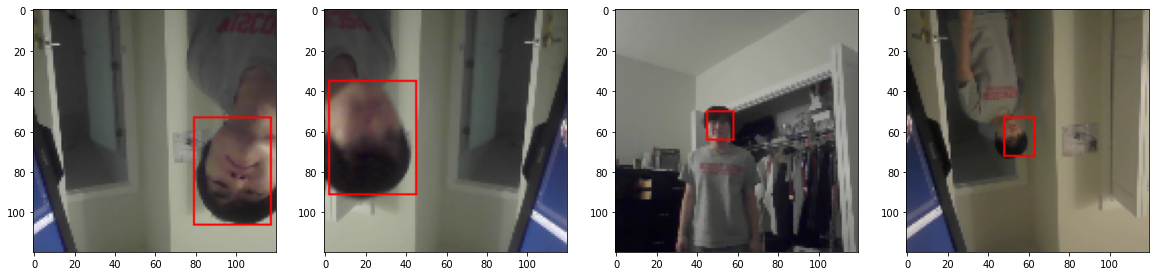

In [40]:
test_iterator = test.as_numpy_iterator()
test_batch = test_iterator.next()
y_hat = face_detection_model.predict(test_batch[0])

fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    
    img = test_batch[0][idx]
    bbox = y_hat[1][idx]

    if y_hat[0][idx] > 0.9:
        cv2.rectangle(
            img,
            tuple(np.multiply(bbox[:2], [120, 120]).astype(int)),
            tuple(np.multiply(bbox[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            1
        )
        ax[idx].imshow(img)

# Save Model

In [43]:
face_detection_model.save('model.h5')

# Load Saved Model

In [44]:
loaded_model = tf.keras.models.load_model('model.h5')

# Real Time Testing

In [ ]:
c = cv2.VideoCapture(0)

while c.isOpened():
    
    _, frame = c.read()
    frame = frame[50:500, 50:500, :]

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized_rgb = tf.image.resize(rgb_frame, (120, 120))

    y_hat = face_detection_model.predict(np.expand_dims(resized_rgb / 255, 0))
    sample_coords = y_hat[1][0]

    if y_hat[0] > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('Face Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

c.release()
cv2.destroyAllWindows()